<a href="https://colab.research.google.com/github/evgeny-kolonsky/Lab4_Nuclear/blob/main/Lab4_Poisson_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Is it Poisson?

**Abstract**

Background radiation [data](https://github.com/tphlabs/data/tree/main/Lab4_Nuclear/2023_12_17) colected at four Geiger-Mueller (GM) sensors in parallel during ~5 hours is considered to test it's likelihood with Poisson distribution against $K_3$ and $\chi^2$ criteria.

There are two parameters of GM setup:
- period duration (5s, 10s)
- number of runs (4000, 2000).

It is found by computational experiment with synthetic data that $K_3$ *skewness* criterion performs well on short periods (small intecities $I$) and big number of observations (runs), while criterion $\chi^2$  prefers long periods (big intesities) to give accurate $p$-value regardless number of runs.

For that reason raw background radiation data collected on short periods (5-10s, $I ~2$ counts/period) is aggregated to long periods (90-300s, $I~30$ counts/period) before testing against $\chi^2$ criterion.

Aggregated to period duration 90s background data has likelihood 73%-100% with Poisson distribution.

Ti-204 radiation [data](https://github.com/tphlabs/data/blob/main/Lab4_Nuclear/2023_12_14/2_Poisson_test_Tl204.tsv) (period 5s, $I~$ 30 counts/period) is tested using this approach is found perfectly fitting Poisson distribution.





In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chisquare, poisson, linregress, kstest
from sklearn.linear_model import LinearRegression
from scipy.special import kl_div

# Criteria

## $\chi^2$ criterion test for Poisson distribution

$$
\chi^2 =  \sum_k \frac{(O_k - E_k)^2}{E_k}
$$

$$ \tilde \chi^2 = \chi^2 / d \leq 1,$$
where $O_k$ - observed events, $E_k$ - expected events, $d$ - number degrees of freedom.

Refer to [Taylor, J.R. (1997) An Introduction to Error Analysis: The Study of Uncertainties in Physical Measurements.]

## $K_3$ test for Poisson distribution
$$
K_3 = \frac{1}{m-1}\sum_{i=1}^{m}\left( n_i - \langle n \rangle \right)^3 \approx \langle n \rangle
$$
where $m$ - number of observations, $\langle n \rangle = \frac{1}{m} \sum n_i$ - mean Intensity.

$$ K_3 / \langle n \rangle \approx 1  $$

# Synthetic data tests

Performing synthetic data test to design experiment with good enough accuracy and reasonable timing.

**Questions:**
- what observation interval should be set?
- how many repeating runs (i.e. observations number) should be performed?
- what test performs reliably enough?

In [2]:
def build_Ok_Ek(s):
  total_events = len(s)
  mean_intensity = s.mean()
  observed = np.bincount(s)
  bins = np.array([bin for bin in range(len(observed))])
  poi = np.array([poisson(mean_intensity).pmf(bin)  for bin in bins])
  # add right tail probability P(x > x_max)
  poi[-1] += poisson(mean_intensity).sf(bins[-1])
  expected = poi * total_events
  return bins, observed, expected

def chi2test(s):
  total_events = len(s)
  bins, observed, expected = build_Ok_Ek(s)

  # calculate chi2 and pvalue
  chi2, pvalue = chisquare(observed, expected, ddof=2) # ddof = 2: total and mean values have been taken out of data
  DOF = len(bins) - 2
  chi2_obtainted = chi2/DOF
  return pvalue

def k3test(s):
  total_events = len(s)
  mean_intensity = s.mean()
  k3 = (s - mean_intensity)**3
  K3 = k3.sum()/(total_events-1)
  return np.abs(K3 / mean_intensity)


## Dependence on number of observations

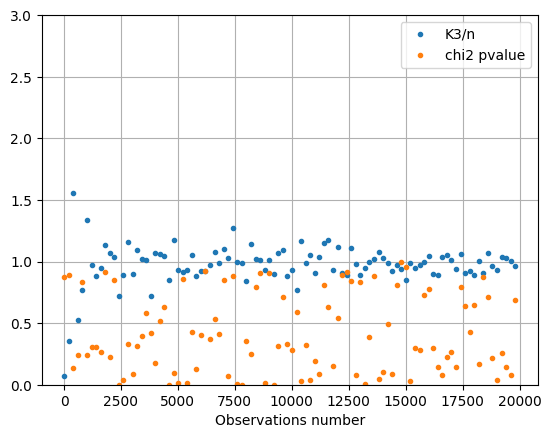

In [3]:
Intensity = 10
testk3 = np.array([[size, k3test(np.random.poisson(Intensity, size=size))] for size in range(10, 20000, 200)]).T
testchi2 = np.array([[size, chi2test(np.random.poisson(Intensity, size=size))] for size in range(10, 20000, 200)]).T
plt.plot(testk3[0], testk3[1], '.', label='K3/n')
plt.plot(testchi2[0], testchi2[1], '.', label='chi2 pvalue')
plt.legend()
plt.xlabel('Observations number')
plt.ylim(0,3)
plt.grid()

## Dependence on Intensity (i.e. on unit observation interval)

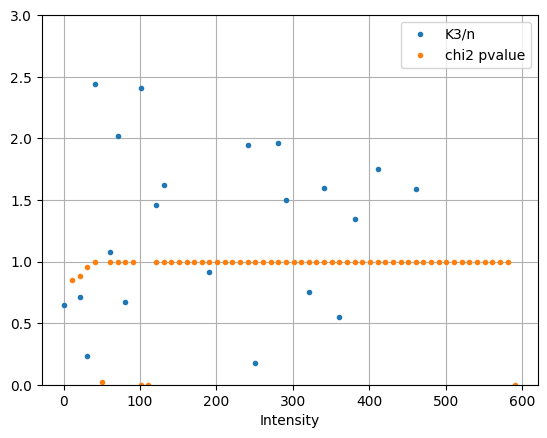

In [4]:
size = 20 # number of observations
testk3 = np.array([[Intensity, k3test(np.random.poisson(Intensity, size=size))] for Intensity in range(1,600, 10)]).T
testchi2 = np.array([[Intensity, chi2test(np.random.poisson(Intensity, size=size))] for Intensity in range(1,600, 10)]).T
plt.plot(testk3[0], testk3[1], '.', label='K3/n')
plt.plot(testchi2[0], testchi2[1], '.', label='chi2 pvalue')
plt.legend()
plt.xlabel('Intensity')
plt.ylim(0,3)
plt.grid()

## Consclusion from synthetic data test

- $K_3$-test works good enough on short intervals (Poisson Intensity < 20) and converges to 1 with growing number of observations $N$.

- $\chi^2$-test perfoms very bad on short intervals and does not improves with growing number of observations $N$. Poisson Intensity should be big enough to get applicable results, say Intensity > 100.

# Get geiger-mueller sensor experimental data

## Background radiation

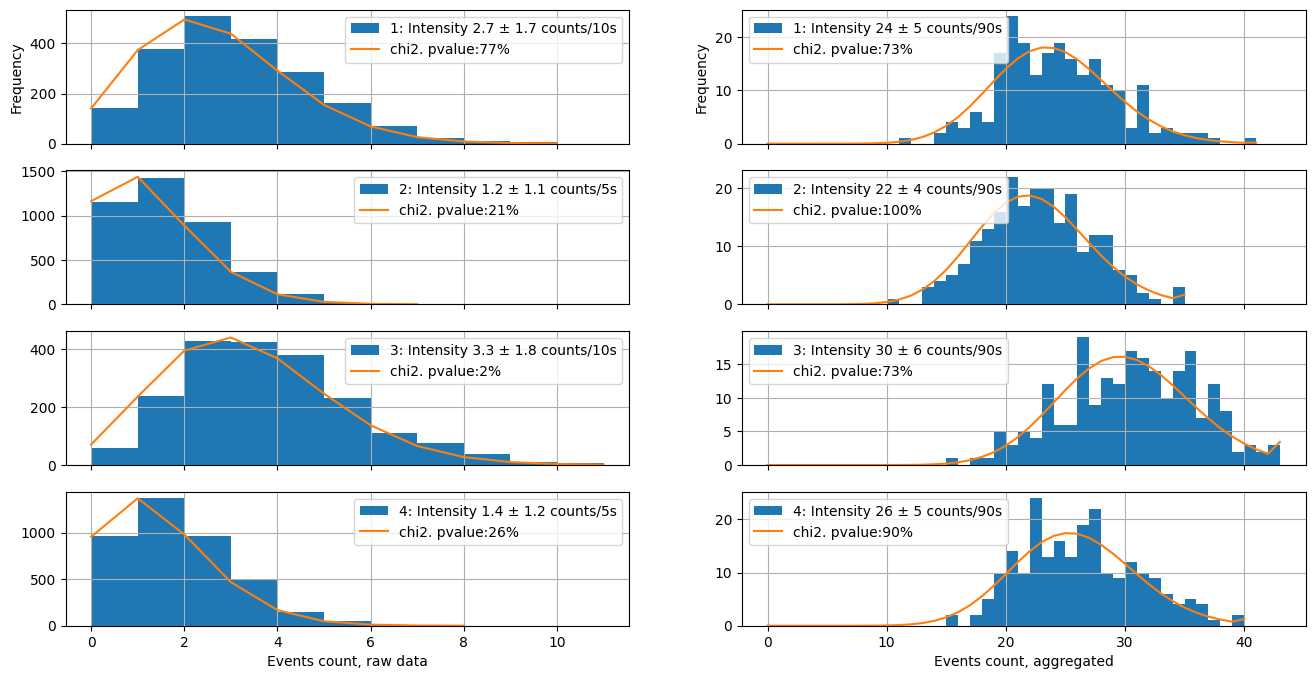

In [5]:
fig, ax = plt.subplots(4,2, figsize=(16,8), sharex='col')

GOOD_INTERVAL = 90 # s

for name in [1, 2, 3, 4]:
  URL = f'https://raw.githubusercontent.com/tphlabs/data/main/Lab4_Nuclear/2023_12_17/{name}.tsv'
  data = np.genfromtxt(URL, delimiter='\t', skip_header=11, usecols=(2,3), dtype='int').T
  s = data[0]
  interval = data[1].mean()
  collect = int(GOOD_INTERVAL / interval) # how many unit intervals be collected in one to get reasonable good Intensity
  # group data into bigger intervals to get Intensity good enough for chi2 testing
  x = np.array([np.sum(s[i : i + collect]) for i in range(0, len(s)// collect * collect, collect)])

  bins, observed, expected = build_Ok_Ek(s)
  ax[name-1, 0].hist(s, density=False, bins=bins,
              label=f'{name}: Intensity {s.mean():.1f} ± {s.std():.1f} counts/{interval:.0f}s');
  ax[name-1, 0].plot(bins, expected, label=f'chi2. pvalue:{chi2test(s):.0%}');
  ax[name-1, 0].legend()
  ax[name-1, 0].grid()

  bins, observed, expected = build_Ok_Ek(x)
  ax[name-1, 1].hist(x, density=False, bins=bins,
              label=f'{name}: Intensity {x.mean():.0f} ± {x.std():.0f} counts/{GOOD_INTERVAL}s');
  ax[name-1, 1].plot(bins, expected, label=f'chi2. pvalue:{chi2test(x):.0%}');
  ax[name-1, 1].legend()
  ax[name-1, 1].grid()

ax[3, 0].set_xlabel('Events count, raw data');
ax[3, 1].set_xlabel('Events count, aggregated');
ax[0, 0].set_ylabel('Frequency');
ax[0, 1].set_ylabel('Frequency');


In [6]:
I_background = np.mean(s/interval)
print(f'Background intensity I {I_background:.2f} counts/s')

Background intensity I 0.29 counts/s


## Ti-204 radiation Poisson distribution test

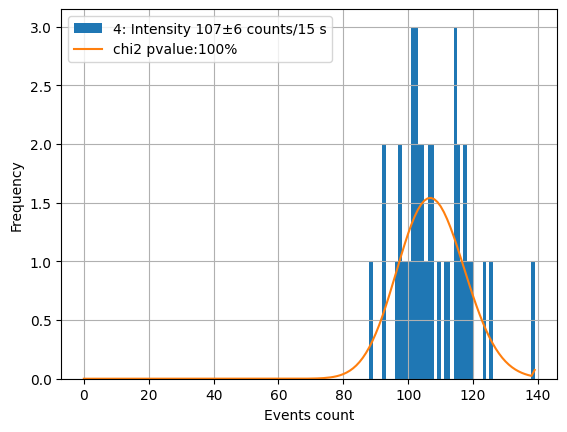

In [7]:
URL = f'https://raw.githubusercontent.com/tphlabs/data/main/Lab4_Nuclear/2023_12_14/2_Poisson_test_Tl204.tsv'
data = np.genfromtxt(URL, delimiter='\t', skip_header=11, usecols=(2,3), dtype='int').T
s = data[0]
interval = data[1].mean()

GOOD_INTERVAL = 15 #s
collect = int(GOOD_INTERVAL / interval) # how many unit intervals be collected in one to get reasonable good Intensity
# group data into bigger intervals to get Intensity good enough for chi2 testing
x = np.array([np.sum(s[i : i + collect]) for i in range(0, len(s)// collect * collect, collect)])

bins, observed, expected = build_Ok_Ek(x)

plt.hist(x, density=False, bins=bins, label=f'{name}: Intensity {x.mean():.0f}±{s.std():.0f} counts/{GOOD_INTERVAL} s')

plt.plot(bins, expected, label=f'chi2 pvalue:{chi2test(x):.0%}');
plt.legend()
plt.xlabel('Events count')
plt.ylabel('Frequency')
plt.grid();

# Performing more tests with radiation sources

**Abstract**

Inverse sqare law of Ti-204 radation [data](https://github.com/tphlabs/data/blob/main/Lab4_Nuclear/2023_12_14/3_Inverse_sqare_Tl204.tsv.txt) is tested and found perfectly fitting the law except of the nearest distance point.

Attentuation of Str-90 radiation [data](https://github.com/tphlabs/data/blob/main/Lab4_Nuclear/2023_12_14/4_Attenuation.txt) through Aliminium plates is tested with result to be discussed (?)

# Inverse square law

$$
I \propto \frac{1}{r^2}\, \implies \, r \propto \frac{1}{\sqrt I}
$$

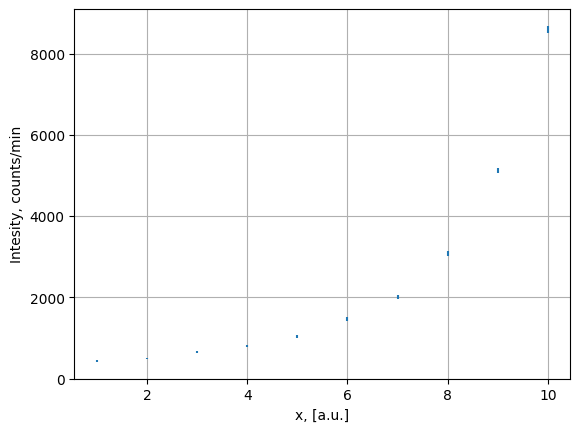

In [8]:
measurements = '''
1 429
2 491
3 646
4 805
5 1033
6 1465
7 2000
8 3077
9 5121
10 8587
'''
data = np.genfromtxt(measurements.splitlines())
x, I = data.T
Ierr = np.sqrt(I)

plt.errorbar(x, I, yerr=Ierr, linestyle='')
plt.xlabel('x, [a.u.]')
plt.ylabel('Intesity, counts/min')
plt.grid()


Offset $r = a -x$  

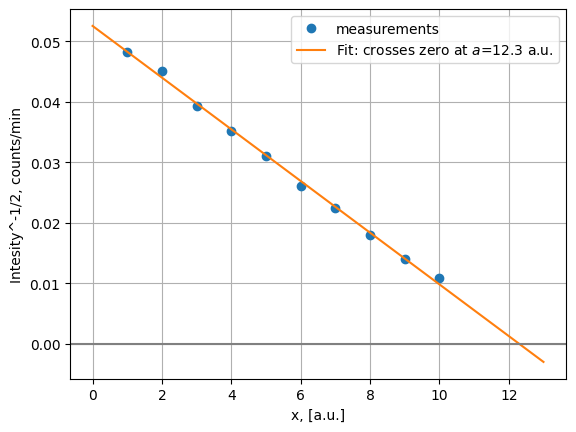

In [9]:
I_inv = 1/np.sqrt(I)
xspace = np.linspace(0, 13)

plt.plot(x, I_inv, 'o', label='measurements')
plt.xlabel('x, [a.u.]')
plt.ylabel('Intesity^-1/2, counts/min')

fit = linregress(x, I_inv)
a = -fit.intercept / fit.slope
plt.plot(xspace, fit.intercept + fit.slope * xspace, label=fr'Fit: crosses zero at $a$={a:.1f} a.u.')
plt.axhline(0, color='gray')
plt.grid()
plt.legend()


Proportionality test

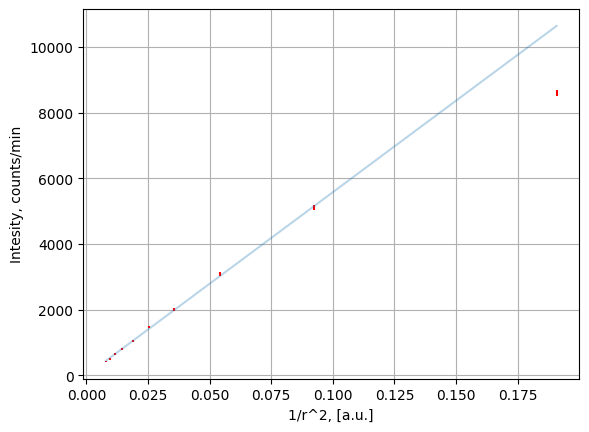

In [10]:
r = a - x
Ierr = np.sqrt(I)

plt.errorbar(1/r**2, I, yerr=Ierr, color='red', linestyle='', label='measurements')
plt.xlabel('1/r^2, [a.u.]')

lr = LinearRegression(fit_intercept=False)

lr.fit(1/r[:-1].reshape(-1, 1)**2, I[:-1])
plt.plot(1/r**2, lr.coef_ /r**2, alpha=0.3, label='linear fit')

plt.ylabel('Intesity, counts/min')
plt.grid()


# Attenuation
$$I = I_0 e^{-\mu d}$$

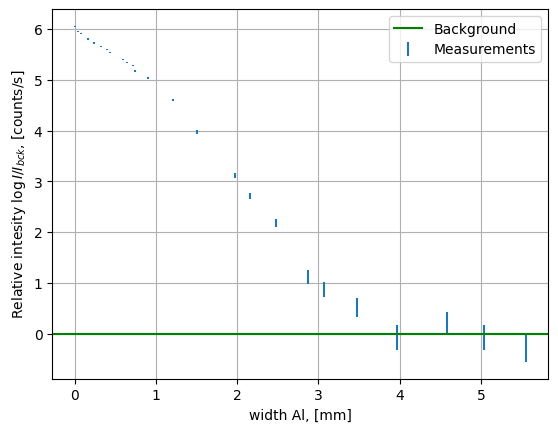

In [11]:
# colums 1 and 2 - width of aluminum plates between radiation source and GM intensity sensor (1e-6m)
# column 3 - Intensity counts/min
measurements = '''
2480 3070  13
2480 0     152
400 240    3592
400 320 3381
0  0   7280
3070 0 41
2160 0 259
1970 0 386
1510 0 913
1210 0 1716
900 0 2666
740 0 3041
590 0 3796
430 0 4362
400 0 4635
320 0 4918
240 0 5268
160 0 5675
80 0 6345
40 0 6593
3070 900 16
3070 1970 16
1970 900 52
1970 1510 29
3070 1510 21
'''
data = np.genfromtxt(measurements.splitlines())
d1, d2, I = data.T
d = d1 + d2
delta = np.sqrt(I) / I # relative I error for I Poisson-distributed
I /= 60 # counst/min -> counts/s
I_rel = I / I_background # relative
I_err = I_rel * delta

plt.errorbar(d*1e-3, np.log(I_rel), yerr=I_err/I_rel, linestyle='', label='Measurements')
plt.xlabel('width Al, [mm]')
plt.ylabel(r'Relative intesity $\log I/I_{bck}$, [counts/s]')
plt.axhline(0, color='green', label='Background')
plt.grid()
plt.legend()


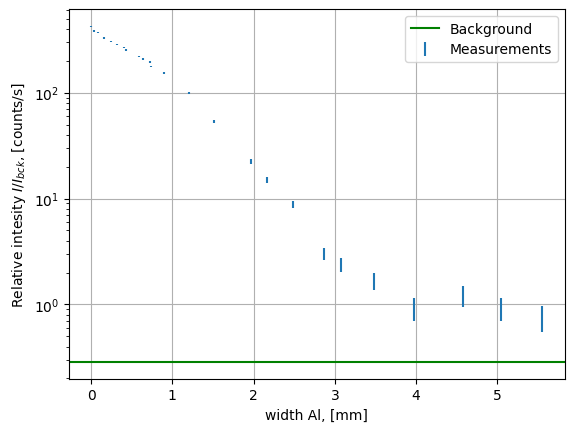

In [12]:
plt.errorbar(d*1e-3, I_rel, yerr=I_err, linestyle='', label='Measurements')
plt.xlabel('width Al, [mm]')
plt.ylabel(r'Relative intesity $I/I_{bck}$, [counts/s]')
plt.axhline(I_background, color='green', label='Background')
plt.grid()
plt.yscale('log')
plt.legend()


# Attenuation coefficents $\mu$ of Aluminium

https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z13.html



In [13]:
coeff = '''
   1.00000E-03  1.185E+03  1.183E+03
   1.50000E-03  4.022E+02  4.001E+02
   1.55960E-03  3.621E+02  3.600E+02
   1.55960E-03  3.957E+03  3.829E+03
   2.00000E-03  2.263E+03  2.204E+03
   3.00000E-03  7.880E+02  7.732E+02
   4.00000E-03  3.605E+02  3.545E+02
   5.00000E-03  1.934E+02  1.902E+02
   6.00000E-03  1.153E+02  1.133E+02
   8.00000E-03  5.033E+01  4.918E+01
   1.00000E-02  2.623E+01  2.543E+01
   1.50000E-02  7.955E+00  7.487E+00
   2.00000E-02  3.441E+00  3.094E+00
   3.00000E-02  1.128E+00  8.778E-01
   4.00000E-02  5.685E-01  3.601E-01
   5.00000E-02  3.681E-01  1.840E-01
   6.00000E-02  2.778E-01  1.099E-01
   8.00000E-02  2.018E-01  5.511E-02
   1.00000E-01  1.704E-01  3.794E-02
   1.50000E-01  1.378E-01  2.827E-02
   2.00000E-01  1.223E-01  2.745E-02
   3.00000E-01  1.042E-01  2.816E-02
   4.00000E-01  9.276E-02  2.862E-02
   5.00000E-01  8.445E-02  2.868E-02
   6.00000E-01  7.802E-02  2.851E-02
   8.00000E-01  6.841E-02  2.778E-02
   1.00000E+00  6.146E-02  2.686E-02
   1.25000E+00  5.496E-02  2.565E-02
   1.50000E+00  5.006E-02  2.451E-02
   2.00000E+00  4.324E-02  2.266E-02
   3.00000E+00  3.541E-02  2.024E-02
   4.00000E+00  3.106E-02  1.882E-02
   5.00000E+00  2.836E-02  1.795E-02
   6.00000E+00  2.655E-02  1.739E-02
   8.00000E+00  2.437E-02  1.678E-02
   1.00000E+01  2.318E-02  1.650E-02
   1.50000E+01  2.195E-02  1.631E-02
   2.00000E+01  2.168E-02  1.633E-02
'''
data = np.genfromtxt(coeff.splitlines())
# energy [MeV]
# mu_gamma, mu_beta [cm^2/g]
energy, mu_gamma, mu_beta = data.T

## Stroncium-90 decay
![image.png](https://radioactivity.eu.com/static/bd2ac4b2ed7ce11af31e688bfcadc8b0/d1f95/Diagramme_Strontium_En.jpg)

In [14]:
E_st90 = 0.546 # MeV
# find nearest mu to Str90 decay energy
idx = np.abs(energy - E_st90).argmin()
rho_Al = 2.7 # g/cm^3
mu_gamma_str90 = mu_gamma[idx] * rho_Al
mu_beta_str90 = mu_beta[idx]   * rho_Al


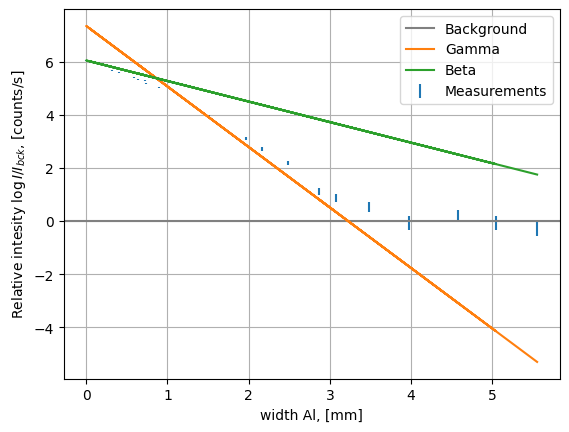

In [15]:
gamma_offset = 1
I_model_gamma = gamma_offset * np.max(I_rel) * np.exp(-mu_gamma_str90 * d*1e-2)
I_model_beta = np.max(I_rel) * np.exp(-mu_beta_str90 * d*1e-2)
plt.errorbar(d*1e-3, np.log(I_rel), yerr=I_err/I_rel, linestyle='', label='Measurements')
plt.xlabel('width Al, [mm]')
plt.ylabel(r'Relative intesity $\log I/I_{bck}$, [counts/s]')
plt.axhline(0, color='gray', label='Background')
offset = 1.3
plt.plot(d*1e-3,  offset + np.log(I_model_gamma), label='Gamma')
plt.plot(d*1e-3, np.log(I_model_beta), label='Beta')
plt.grid()
plt.legend()